# Ridge Regression

In [13]:
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [15]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [16]:
# Choose a macro target and predictors
target = 'GDP Monthly' 
crypto_cols = ['Bitcoin', 'Tether'] 

# Optional: include lagged values of macro variable as features
df['GDP Monthly_lag1'] = df['GDP Monthly'].shift(1)
df['GDP Monthly_lag2'] = df['GDP'].shift(2)
X = df[crypto_cols + ['GDP Monthly_lag1', 'GDP Monthly_lag2']].dropna()
y = df[target].shift(-1).dropna()[:len(X)]  # one-step-ahead forecast

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Try different alphas (regularization strengths)
alphas = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=5))
ridge_cv.fit(X_scaled, y)

print("Best alpha:", ridge_cv.alpha_)
print("R^2 score:", ridge_cv.score(X_scaled, y))

Best alpha: 0.0001
R^2 score: 0.9999999999853918


In [19]:
X_base = df[['GDP Monthly_lag1', 'GDP Monthly_lag2']].dropna()
y_base = df[target].shift(-1).dropna()[:len(X_base)]
X_base_scaled = scaler.fit_transform(X_base)
X_full_scaled = scaler.fit_transform(X[crypto_cols + ['GDP Monthly_lag1', 'GDP Monthly_lag2']])

In [20]:
ridge = Ridge(alpha=ridge_cv.alpha_)
cv = TimeSeriesSplit(n_splits=5)
base_score = cross_val_score(ridge, X_base_scaled, y_base, cv=cv, scoring='r2').mean()
full_score = cross_val_score(ridge, X_full_scaled, y, cv=cv, scoring='r2').mean()
print("Baseline R²:", base_score)
print("Crypto-enhanced R²:", full_score)
print("Improvement:", full_score - base_score)

Baseline R²: 0.9999974735900764
Crypto-enhanced R²: 0.9999964658988908
Improvement: -1.0076911856060633e-06


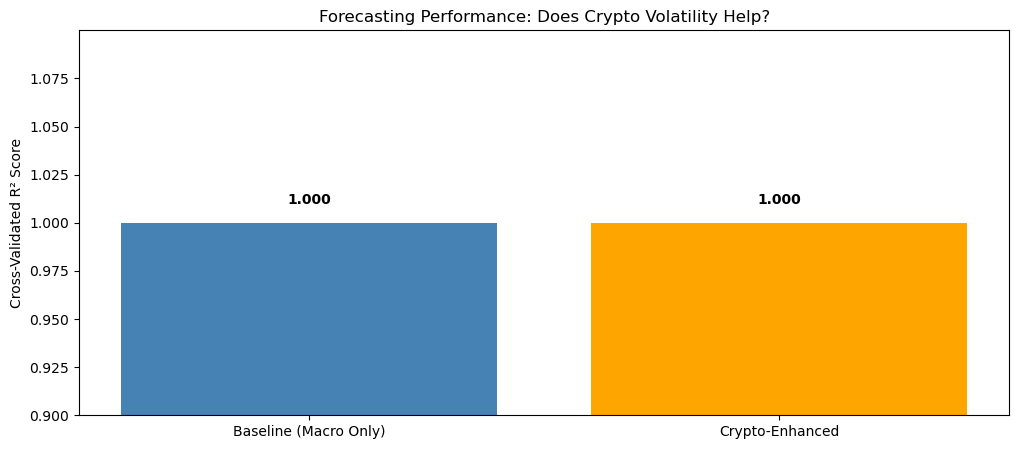

In [21]:
labels = ['Baseline (Macro Only)', 'Crypto-Enhanced']
scores = [base_score, full_score]
plt.figure(figsize=(12, 5))
plt.bar(labels, scores, color=['steelblue', 'orange'])
plt.ylabel('Cross-Validated R² Score')
plt.title('Forecasting Performance: Does Crypto Volatility Help?')
plt.ylim(min(scores) - 0.1, max(scores) + 0.1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

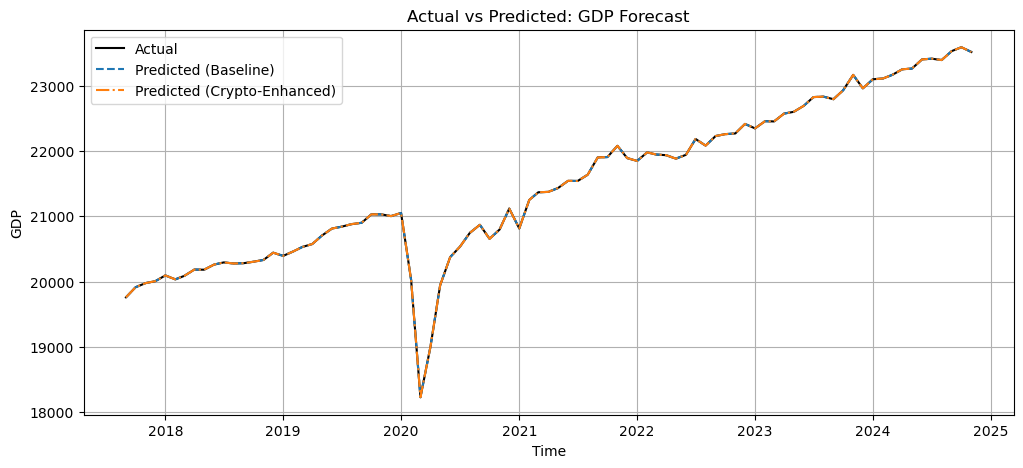

In [22]:
# Fit models on full data for 1-step ahead predictions
ridge_base = Ridge(alpha=ridge_cv.alpha_).fit(X_base_scaled, y_base)
ridge_full = Ridge(alpha=ridge_cv.alpha_).fit(X_full_scaled, y)

pred_base = ridge_base.predict(X_base_scaled)
pred_full = ridge_full.predict(X_full_scaled)

plt.figure(figsize=(12, 5))
plt.plot(y_base.index, y_base, label='Actual', color='black')
plt.plot(y_base.index, pred_base, label='Predicted (Baseline)', linestyle='--')
plt.plot(y.index, pred_full, label='Predicted (Crypto-Enhanced)', linestyle='-.')
plt.title('Actual vs Predicted: GDP Forecast')
plt.legend()
plt.ylabel('GDP')
plt.xlabel('Time')
plt.grid(True)
plt.show()